In [1]:
%matplotlib inline
from IPython import display
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
import copy
from matplotlib import cm

pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86"
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04"
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41"
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73"
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48"


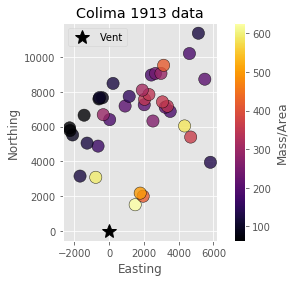

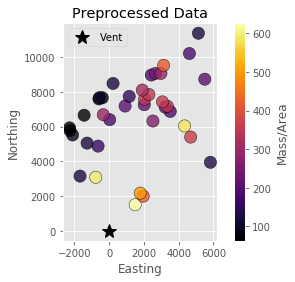

In [72]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display.display(raw_df.head())

vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

# obs_df = obs_df.drop([16, 18, 17, 37, 31])
#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)
obs_df = obs_df.sort_values(by=['radius'])

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [73]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

display.display(config)
display.display(globs)



{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5.0,
 'MIN_GRAINSIZE': 4.0,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

In [74]:
theo_phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display.display(pd.DataFrame(theo_phi_steps))

,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2
7,2.5,"1,652.5","[2,3)",2,0.0474595,3
8,3.5,"1,862","[3,4)",3,0.0224962,4


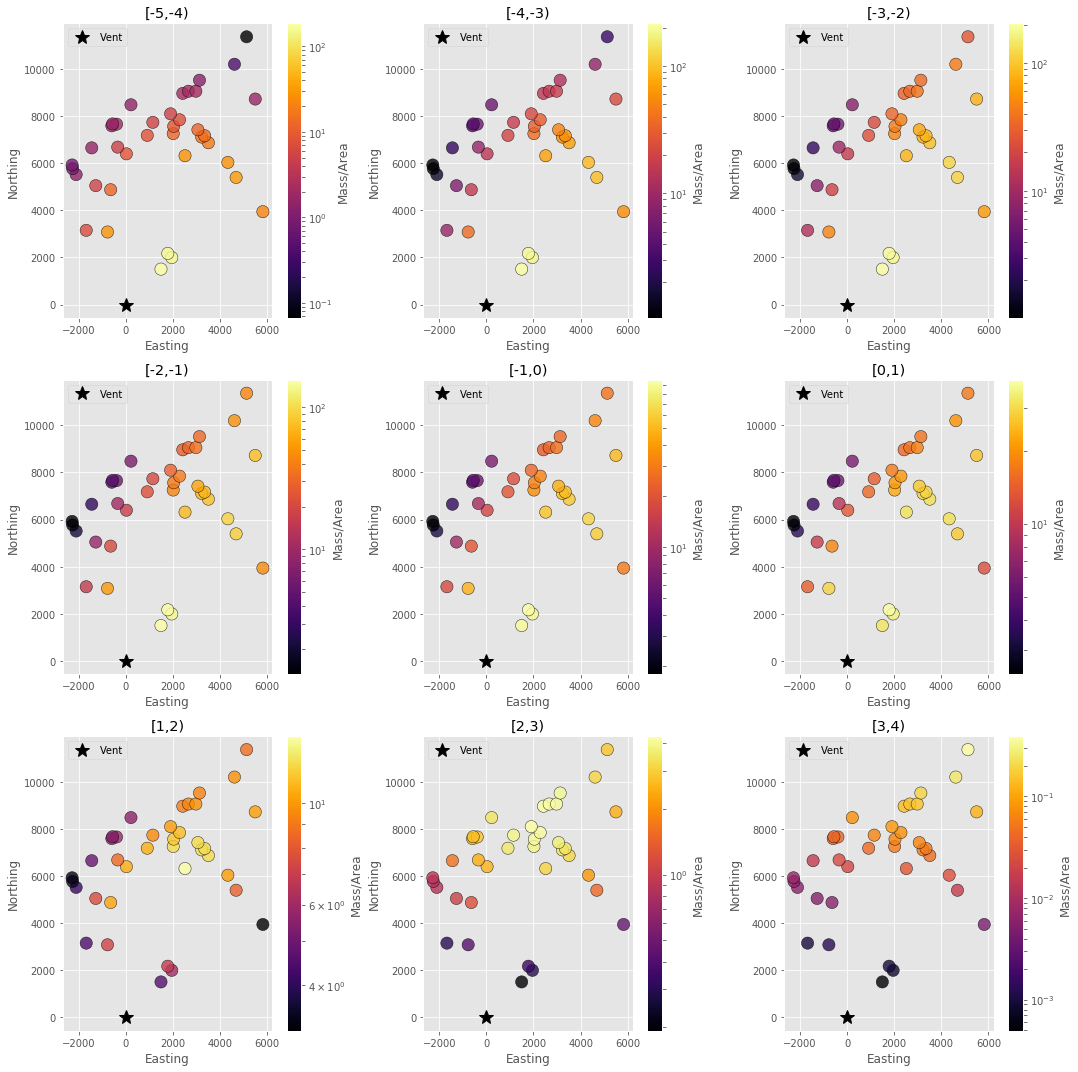

Int64Index([16, 18, 17, 37, 31, 36, 35, 34, 33, 32,  6, 28, 11, 30, 20, 21,  7,
            22, 12, 29, 14,  5, 24, 23,  4, 19, 26, 25, 27,  1, 13,  8,  3, 15,
             0,  2,  9, 10],
           dtype='int64')


In [75]:
sep_phis = []

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, phi in enumerate(theo_phi_steps):
    df, _, _, _ = io.read_tephra2("data/colima/colima_gs_trial/colima_%d_out.txt"%i)
    sep_phis += [df]
    vis.plot_sample(sep_phis[i], vent=(0,0), ax=axs[i], 
                    title="%s"%phi["interval"], cbar_label="Mass/Area")
plt.tight_layout()
plt.show()

print(obs_df.index)

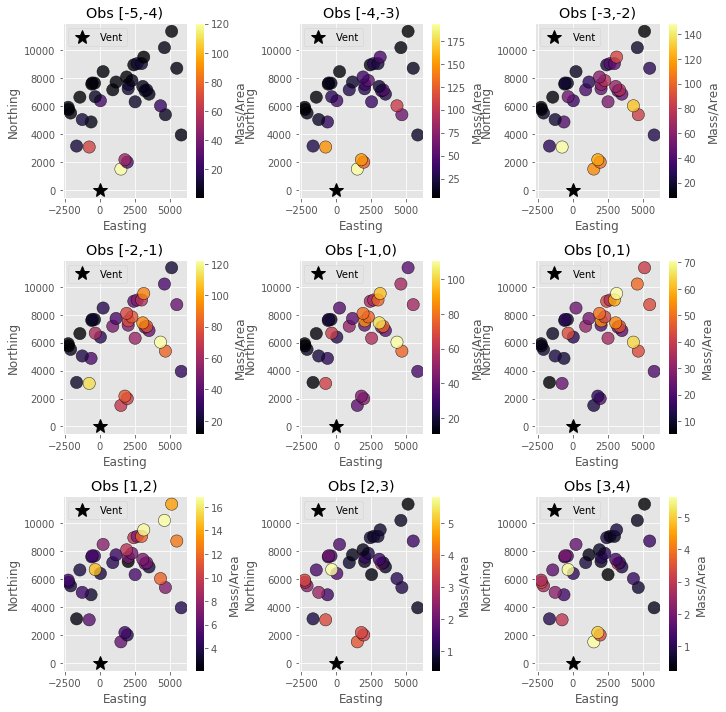

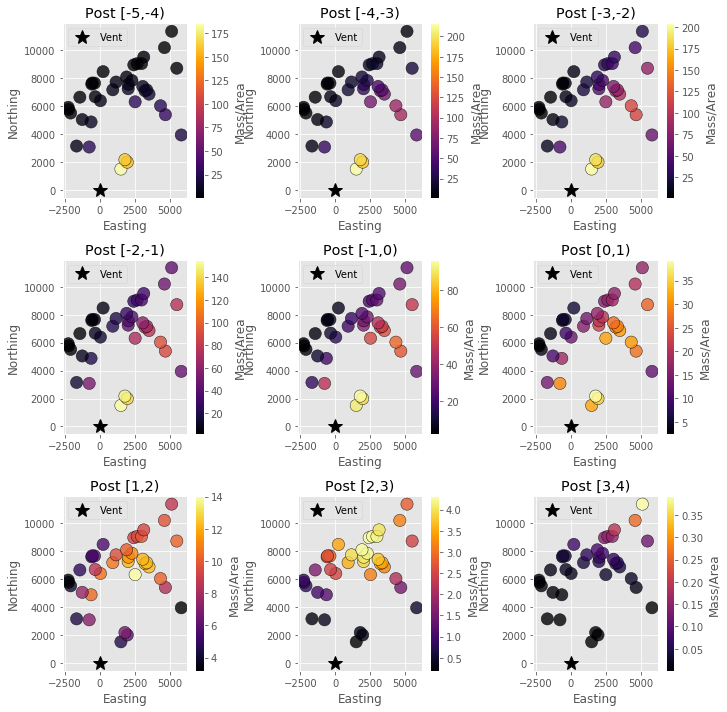

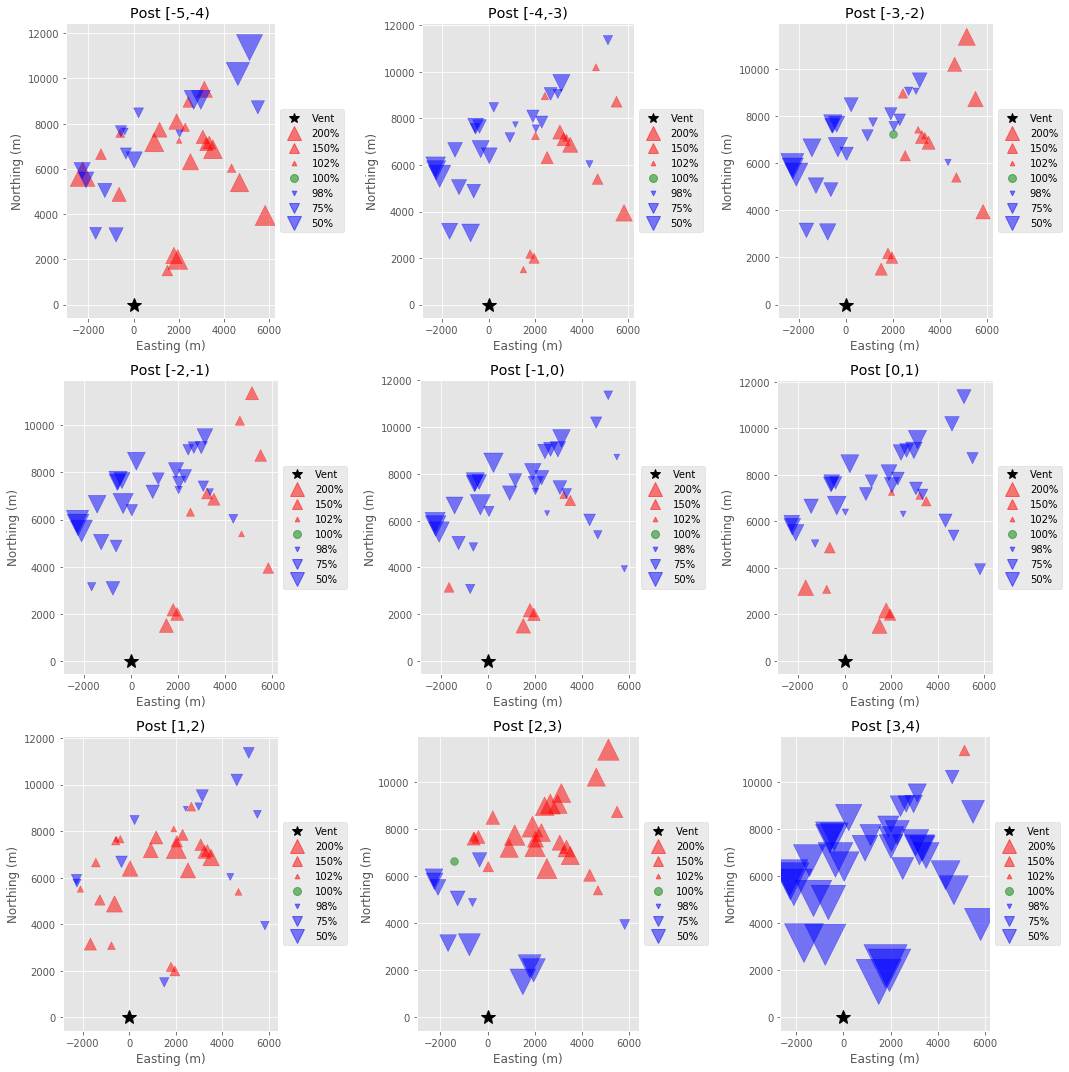

In [76]:
observation_phis = []
posterior_phis = []

prior_phi_steps = theo_phi_steps.copy()

for j, phi_step in enumerate(theo_phi_steps):
    phi_obs = obs_df.copy()
    phi_obs["MassArea"] = phi_obs["MassArea"]*phi_obs[phi_step["interval"]]/100
    phi_obs[phi_step["interval"]] = 100
    bounds=(0, 200)

    observation_phis += [phi_obs]

    phi_post = sep_phis[j].copy()
    phi_post["radius"] = np.sqrt(phi_post["Easting"]**2 + phi_post["Northing"]**2)
    phi_post = phi_post.sort_values(by=['radius'])
    phi_post["Residual"] = phi_post["MassArea"].values/phi_obs["MassArea"].values
    
    posterior_phis += [phi_post]

fig, axs = plt.subplots(3,3, figsize=(
            10, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False,#bounds=bounds, 
                   title="Obs %s"%phi_step["interval"], cbar_label="Mass/Area", ax=axs[j])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            10, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_sample(posterior_phis[j], vent=(0,0), log=False,#bounds=bounds, 
                   title="Post %s"%phi_step["interval"], cbar_label="Mass/Area", ax=axs[j])
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_residuals(posterior_phis[j], vent=(0,0), plot_type="size",
                   title="Post %s"%phi_step["interval"], ax=axs[j])
    
plt.tight_layout()
plt.show()

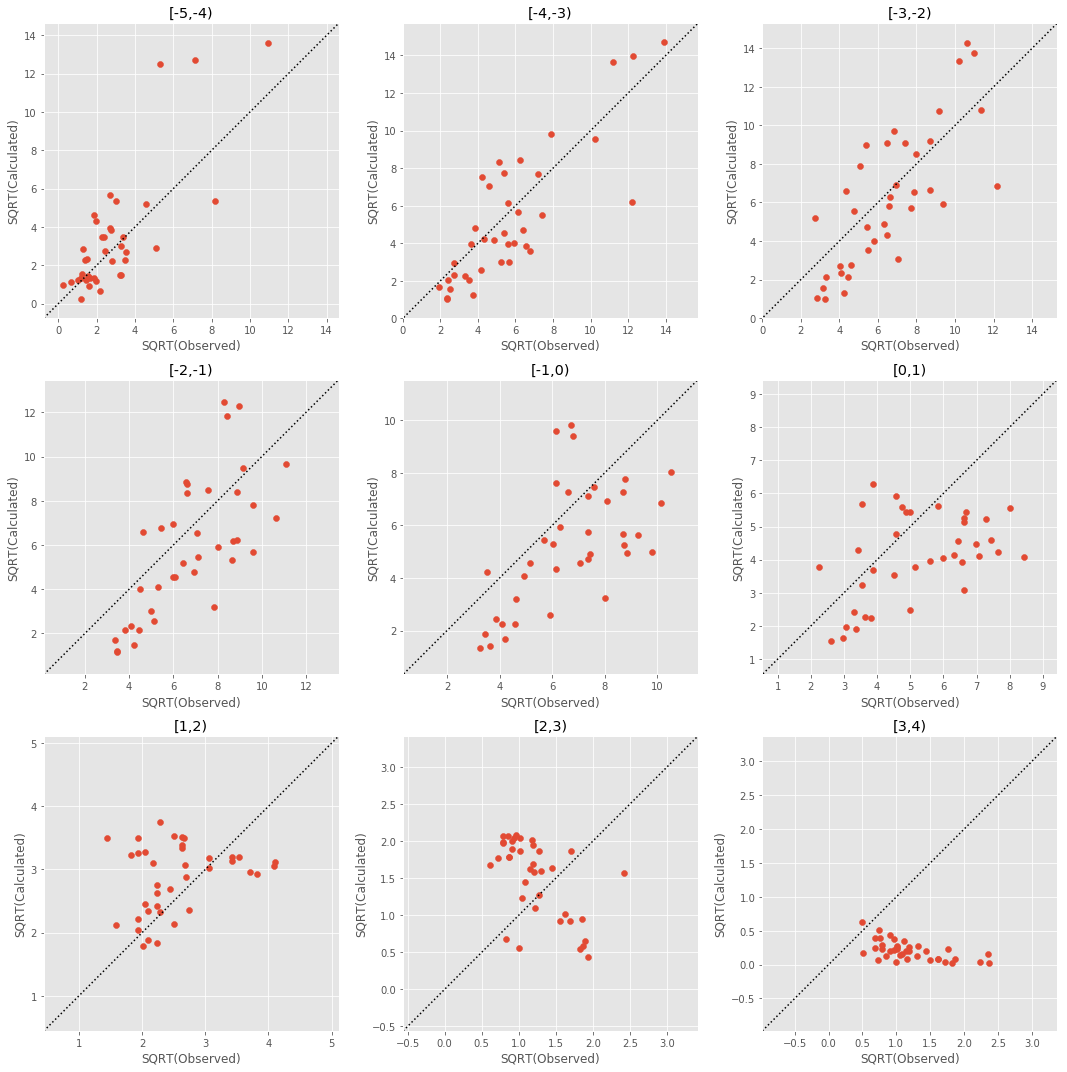

In [77]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    min_mass = min((min(observation_phis[j]["MassArea"].values), min(posterior_phis[j]["MassArea"].values)))
    max_mass = max((max(observation_phis[j]["MassArea"].values), max(posterior_phis[j]["MassArea"].values)))
    axs[j].scatter(np.sqrt(observation_phis[j]["MassArea"].values), np.sqrt(posterior_phis[j]["MassArea"].values))
    axs[j].plot([-100,100],[-100,100], "k:")
    axs[j].set_xlabel("SQRT(Observed)")
    axs[j].set_ylabel("SQRT(Calculated)")
    axs[j].set_aspect('equal', 'box')
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    axs[j].set_ylim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    
plt.tight_layout()
plt.show()

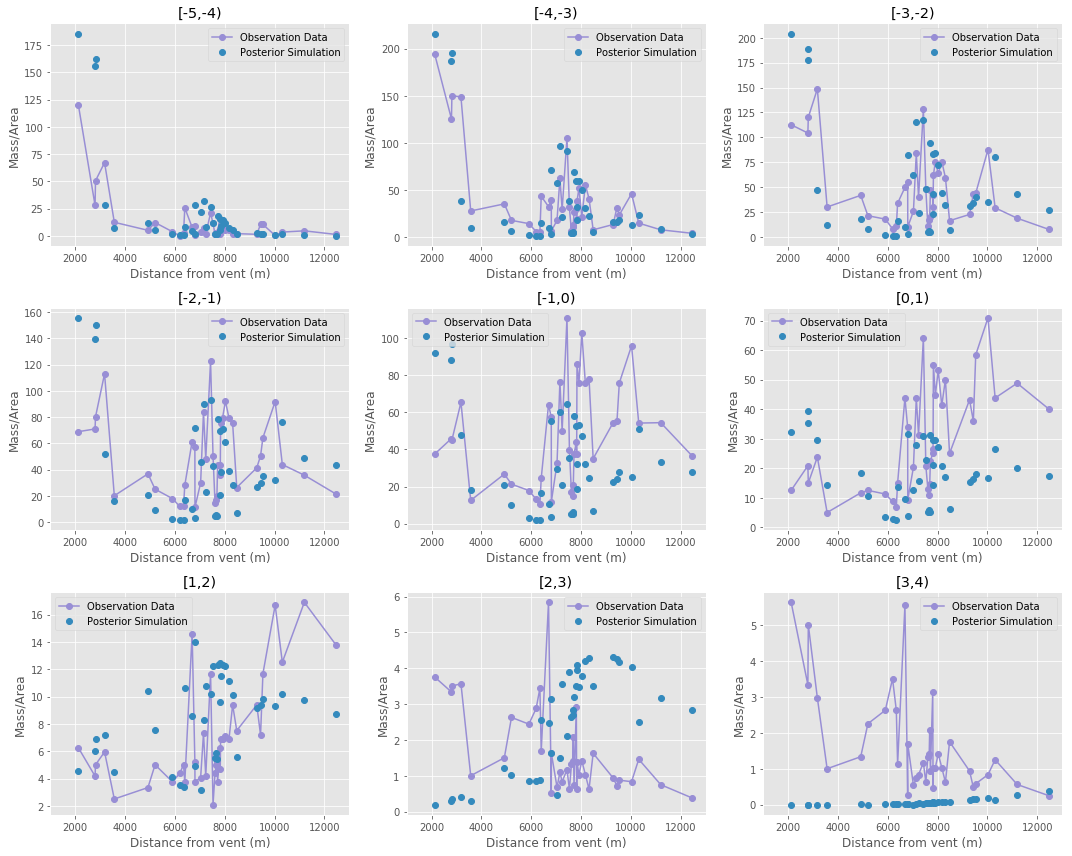

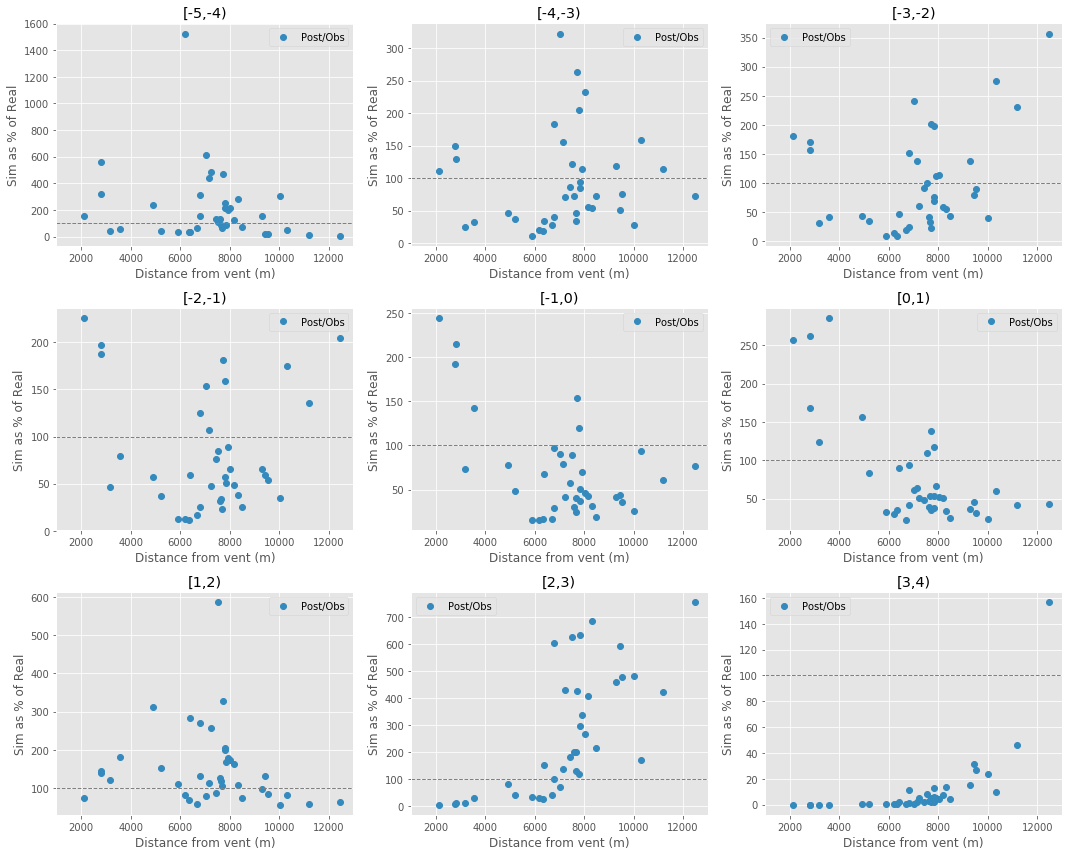

In [78]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"].values, observation_phis[j]["MassArea"].values, 'C2o-', label="Observation Data")
    axs[j].plot(posterior_phis[j]["radius"].values, posterior_phis[j]["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[j].legend()
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlabel("Distance from vent (m)")
    axs[j].set_ylabel("Mass/Area")
    axs[j].set_xlim(1000, 13000)
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(posterior_phis[j]["radius"].values, posterior_phis[j]["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[j].axhline(100, linestyle="--", lw=1, c="gray")  
    axs[j].legend()
    axs[j].set_xlabel("Distance from vent (m)")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_ylabel("Sim as % of Real")
    axs[j].set_xlim(1000, 13000)
    
plt.tight_layout()
plt.show()

In [79]:
def misfit_sse(observed, expected):
    return ((observed - expected)**2)/expected

contributions = np.zeros((len(prior_phi_steps), len(observation_phis[0])))
print(contributions.shape)
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["MassArea"].values
    for i in range(len(posterior_phis[j])):
        observed = observation_phis[j]["MassArea"].values[i]
        expected = posterior_phis[j]["MassArea"].values[i]
        misfit = ((observed - expected)**2)/expected
        contributions[j,i] = misfit

point_contributions = np.sum(contributions, 0)
phi_contributions = np.sum(contributions, 1)


(9, 38)


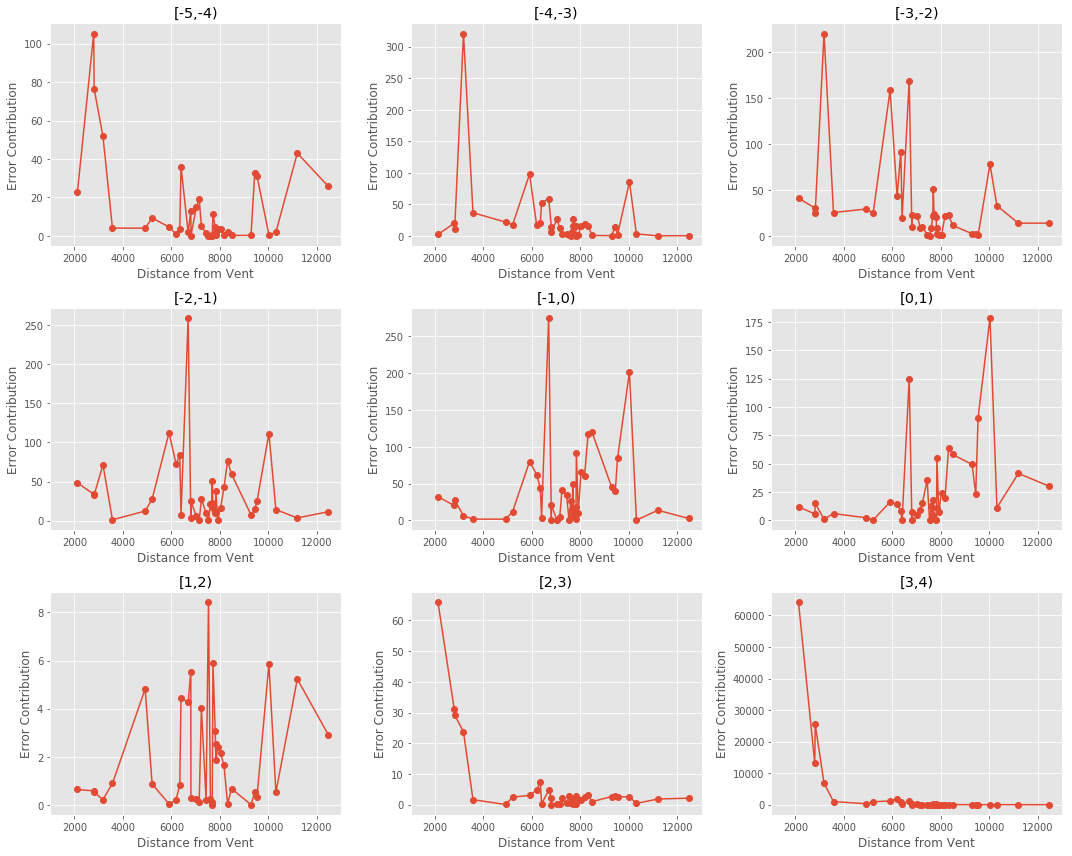

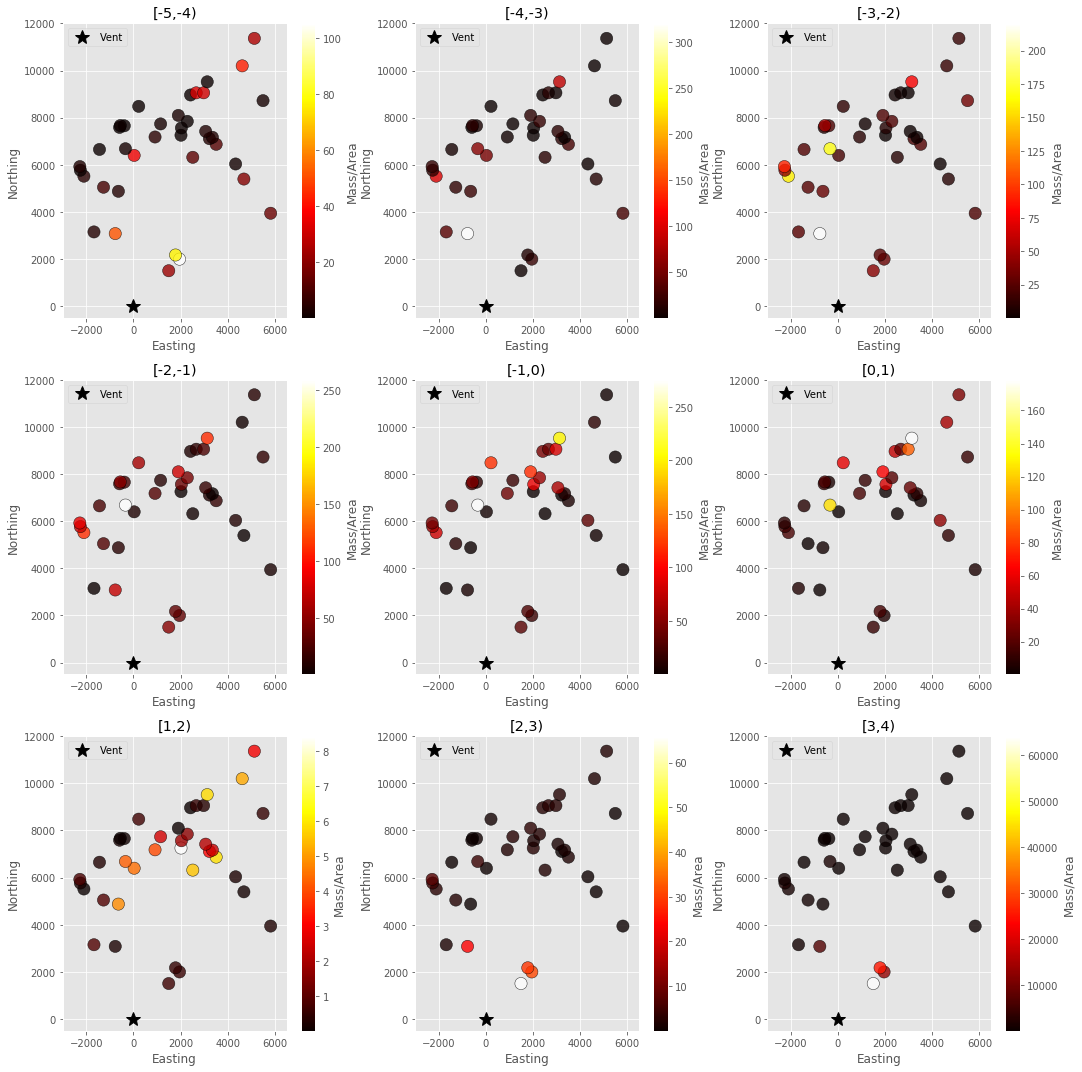

In [83]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"], contributions[j,:], "C0o-")
    axs[j].set_xlabel("Distance from Vent")
    axs[j].set_ylabel("Error Contribution")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim(1000, 13000)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["Contributions"] = contributions[j,:]
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False, values="Contributions",
                title="Error Contributions", cbar_label="Mass/Area", ax = axs[j], cmap="hot")
    axs[j].set_xlim([-3000, 6500])
    axs[j].set_ylim([-500, 12000])
    axs[j].set_title(phi_step["interval"])

plt.tight_layout()
plt.show()

In [85]:
row_labels = [phi["interval"] for phi in prior_phi_steps]

cont_df = pd.DataFrame(data=contributions.T, columns=row_labels, index = obs_df.index)

#Total sum per column: 
cont_df.loc['Total',:]= cont_df.sum(axis=0)

#Total sum per row: 
cont_df.loc[:,'Total'] = cont_df.sum(axis=1)

display.display(cont_df)

,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",Total
16,23.0116,2.26421,41.0998,48.3082,32.0587,11.9998,0.637695,65.9167,"64,179.8","64,405.1"
18,105.213,20.1281,30.397,33.7131,20.216,5.82402,0.57693,31.0872,"13,106.5","13,353.7"
17,76.4593,10.4798,24.9992,32.8947,27.545,15.1168,0.518179,29.1957,"25,498.5","25,715.7"
37,51.755,320.768,220.346,71.4049,6.32018,1.12049,0.21794,23.7495,"6,846.68","7,542.37"
31,4.0627,36.7158,25.3984,1.06013,1.60156,6.04616,0.886585,1.61306,985.793,"1,063.18"
36,4.04974,21.9092,29.2884,12.2101,1.63198,2.39931,4.82131,0.0680729,298.73,375.108
35,9.30351,17.7996,24.9527,27.4448,11.9927,0.389898,0.867787,2.4578,914.379,"1,009.59"
34,4.66157,98.0383,158.635,112.522,79.9731,16.323,0.0357251,3.01936,"1,191.54","1,664.75"
33,0.833605,17.5067,43.2863,72.263,62.2317,14.0842,0.20987,4.80801,"1,874.41","2,089.63"
32,3.70704,20.0123,91.6613,84.3946,44.1207,8.52256,0.825832,7.36089,952.844,"1,213.45"


In [94]:
disp_cols = ["Easting",
            "Northing",
            "MassArea",
            "radius"]

display.display(observation_phis[-1][disp_cols].head())

display.display(posterior_phis[-1][disp_cols].head())

display.display(obs_df.head())

,Easting,Northing,MassArea,radius
16,1499,1506,5.6322,"2,124.86"
18,1957,1997,3.3376,"2,796.04"
17,1787,2173,5.0064,"2,813.41"
37,-770,3082,2.97255,"3,176.73"
31,-1673,3152,1.00128,"3,568.48"


,Easting,Northing,MassArea,radius
16,1499,1506,0.000494176,"2,124.86"
18,1957,1997,0.000849492,"2,796.04"
17,1787,2173,0.000982576,"2,813.41"
37,-770,3082,0.00128944,"3,176.73"
31,-1673,3152,0.00101495,"3,568.48"


,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86",100
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04",100
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41",100
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73",100
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48",100
